In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
from pydub import AudioSegment

import qiskit
from qiskit import QuantumCircuit, QuantumRegister, Aer, execute, transpile
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import QFT
from qiskit import quantum_info as qi

import quantumaudio as qa

In [2]:
#Reading the audio file
audio = AudioSegment.from_file('custom_dtmf_signal.mp3') 
sample_rate = audio.frame_rate
data = audio.get_array_of_samples()[:]
N = len(data)

In [3]:
N

22050

Text(0, 0.5, 'amplitude')

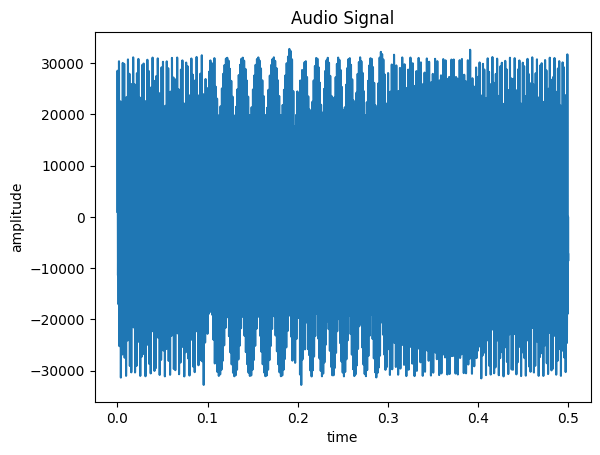

In [4]:
#Plotting the Audio Signal 
time = np.arange(len(data))/sample_rate
plt.plot(time,data)
plt.title('Audio Signal')
plt.xlabel('time')
plt.ylabel('amplitude')

Text(0, 0.5, 'amplitude')

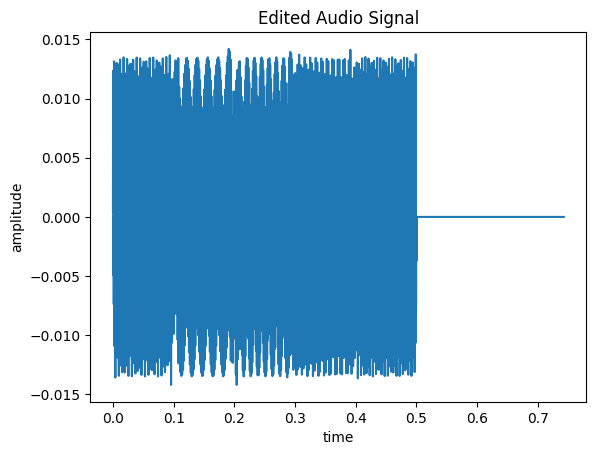

In [5]:
#Extending the data to make N=2**n where n is number of qubits used to encode the audio in a quantum circuit

n_qubits = math.ceil(np.log2(N))
data.extend([0] * (2**n_qubits-N))
data = data/np.linalg.norm(data)     #Normalizing the data array
N = len(data)                        #New length of the data
time = np.arange(N)/sample_rate
plt.plot(time,data)
plt.title('Edited Audio Signal')
plt.xlabel('time')
plt.ylabel('amplitude')

In [6]:
t_hum = 1/50  #(in seconds)
Nmin = t_hum*sample_rate
Nwin = int(2**(math.ceil(np.log2(Nmin))-1))  #To make the algorithm 2**n
s = 4 #slide
Ns = math.floor((N-Nwin)/(Nwin/s))  #Number of windows

## Quantum Fourier Transform

In [7]:
#Defining qft algorithm
def qft(n):
    """Creates an n-qubit QFT circuit"""
    circuit = QuantumCircuit(n)
    def swap_registers(circuit, n):
        for qubit in range(n//2):
            circuit.swap(qubit, n-qubit-1)
        return circuit
    def qft_rotations(circuit, n):
        """Performs qft on the first n qubits in circuit (without swaps)"""
        if n == 0:
            return circuit
        n -= 1
        circuit.h(n)
        for qubit in range(n):
            circuit.cp(np.pi/2**(n-qubit), qubit, n)
        qft_rotations(circuit, n)
    
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

In [8]:
#window = np.ones(Nwin)
window = np.hamming(Nwin)
#window = np.hanning(Nwin)

In [14]:
#Each window corresponds to one quantum circuit with Nwin points.

circuits = []                    #To store all the circuits corresponding to windows
n_qubits = int(math.log2(Nwin))  #Number of qubits require to represent Nwin data points
for i in range(Ns-1):
    my_data = (data[i*int(Nwin/s):(i*int(Nwin/s))+Nwin] * window)

    #Encoding the data array on the quantum circuit by using 'qpam' method - which takes the input data, normalizes it and initializes on circuit of n qubits
    qsound_qpam = qa.QuantumAudio('qpam')
    qsound_qpam.load_input(my_data)
    qsound_qpam.prepare()
    qc = qsound_qpam.circuit
    
    #Creating a circuit with quantum fourier transform alogithm
    qft_circuit = qft(n_qubits)

    #Merging both the initialized circuit and qft circuit
    audio_qc = qc.compose(qft_circuit,list(np.arange(n_qubits)))
    circuits.append(audio_qc)

For this input, the QPAM representation will require:
         9 qubits for encoding time information and 
         0 qubits for encoding ampĺitude information.
For this input, the QPAM representation will require:
         9 qubits for encoding time information and 
         0 qubits for encoding ampĺitude information.
For this input, the QPAM representation will require:
         9 qubits for encoding time information and 
         0 qubits for encoding ampĺitude information.
For this input, the QPAM representation will require:
         9 qubits for encoding time information and 
         0 qubits for encoding ampĺitude information.
For this input, the QPAM representation will require:
         9 qubits for encoding time information and 
         0 qubits for encoding ampĺitude information.
For this input, the QPAM representation will require:
         9 qubits for encoding time information and 
         0 qubits for encoding ampĺitude information.
For this input, the QPAM represent

In [15]:
#Extracting the output vector of the each circuit (In this case fourier coeffiecients)
sv = []
for i in range(len(circuits)):
    sv0 = qi.Statevector.from_instruction(circuits[i]).to_dict()
    sv.append(sv0)

In [16]:
def get_bit_string(n, n_qubits):
    """Returns the binary string of an integer with n_qubits characters"""
    assert n < 2**n_qubits, 'n too big to binarise, increase n_qubits or decrease n'
    bs = "{0:b}".format(n)
    bs = "0"*(n_qubits - len(bs)) + bs
    return bs

def get_fft_from_sv(sv, n_qubits):
    """Returns the counts in order of the digital value of the key which is the measured qbit state, i.e. in frequency order"""
    out = []
    keys = sv.keys()
    for i in range(2**n_qubits):
        id = get_bit_string(i, n_qubits)
        if(id in keys):
            out.append(sv[id])
        else:
            out.append(0)
    return out

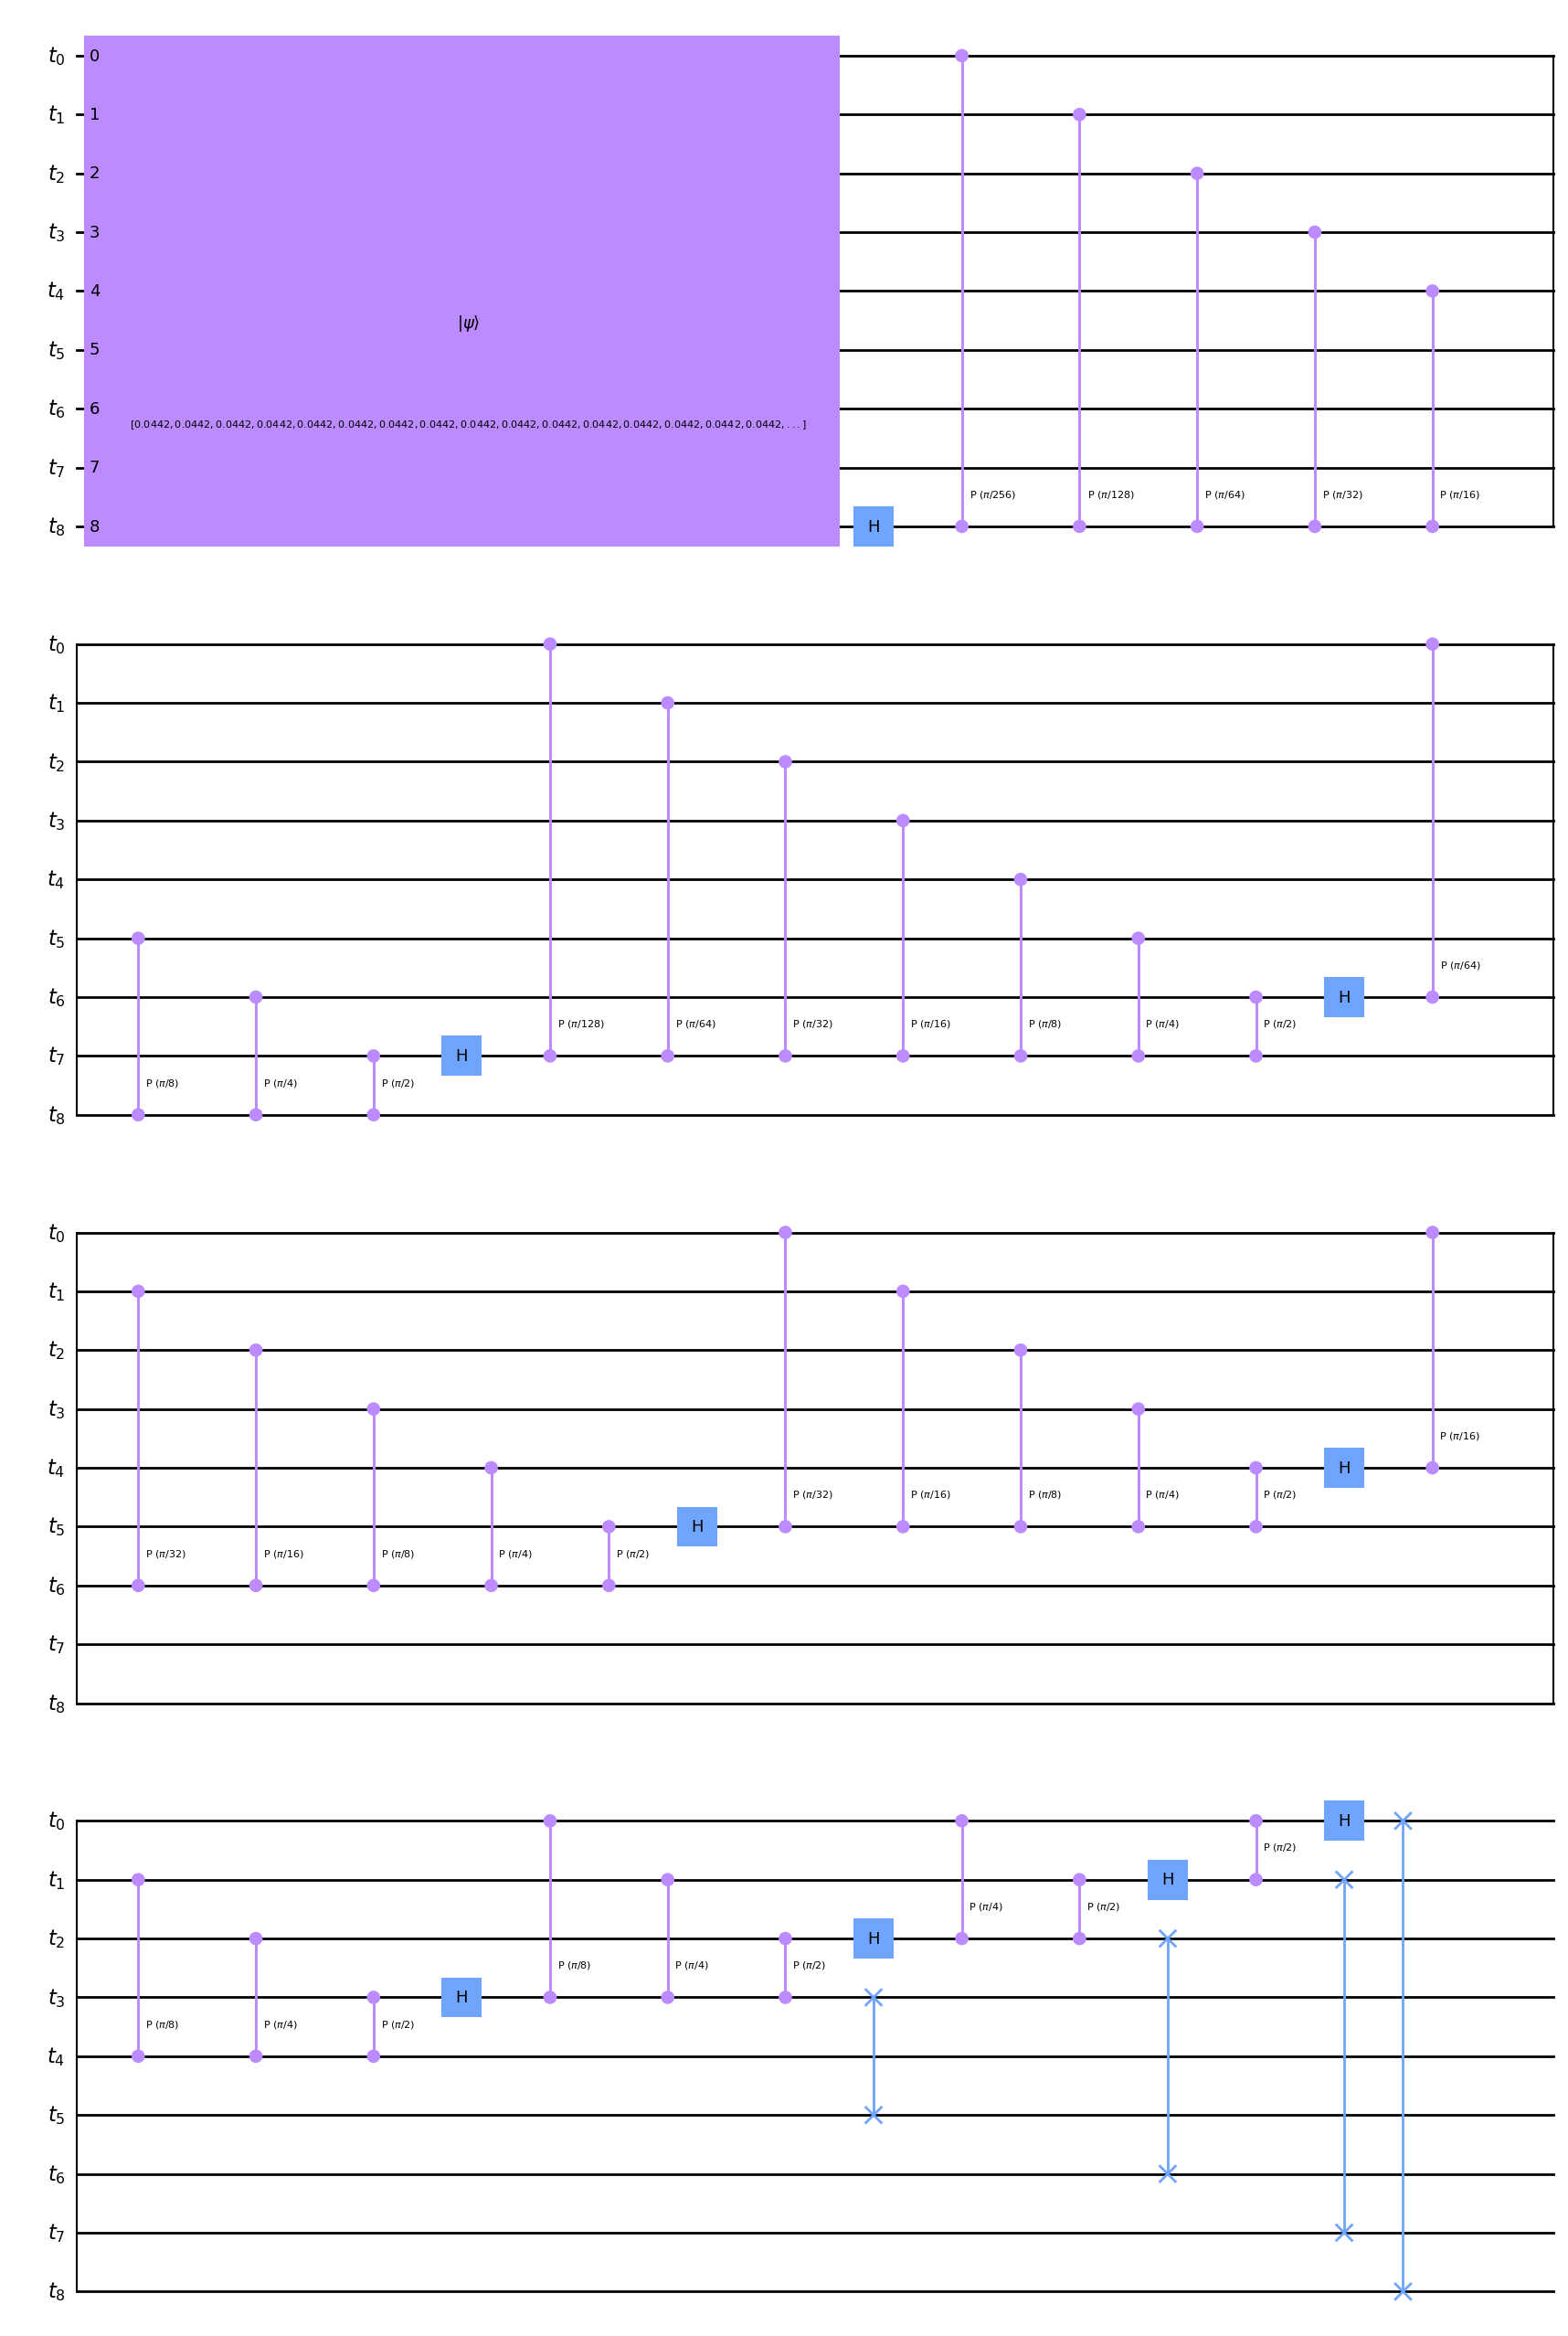

In [17]:
#Visualizing one of the circuit corresponding to a window
circuits[0].draw('mpl')

In [18]:
#Updating fourier coefficients as qft

qft = np.zeros([len(sv[0]),len(sv)],dtype=complex)
for i in range(len(sv)):
    qft[:,i] = get_fft_from_sv(sv[i],n_qubits)

## Classical Fourier Transform

In [20]:
#Obtaining fourier spectogram classically
fft = np.zeros((Nwin,Ns),dtype='complex')
for i in range(Ns-1):
    my_data = (data[:][i*int(Nwin/s):(i*int(Nwin/s))+Nwin] * window)
    my_data = my_data/np.linalg.norm(my_data)
    fft[:,i] = np.fft.fft(my_data)

/tmp/ipykernel_529/745719296.py:4: RuntimeWarning: invalid value encountered in divide
  my_data = my_data/np.linalg.norm(my_data)


/tmp/ipykernel_529/2558368253.py:4: RuntimeWarning: divide by zero encountered in log
  pcm1 = axs[0].pcolorfast(10*np.log(np.abs(fft))) #log scale (in decibels)


Text(0.5, 1.0, 'DTMF Spectrogram using Quantum FT')

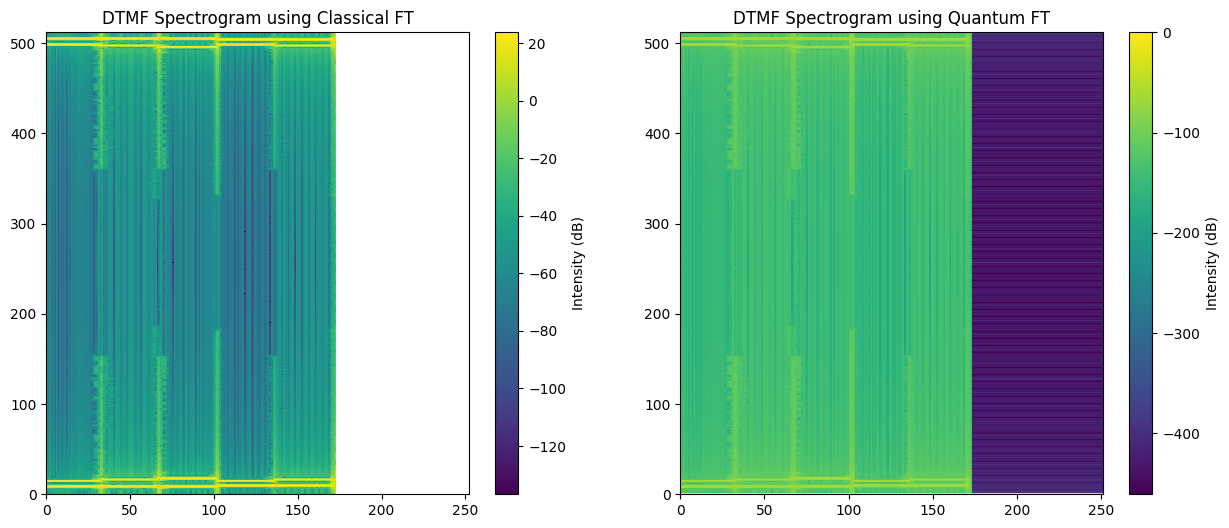

In [22]:
#Comparing spectogram from both
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Plotting the first graph
pcm1 = axs[0].pcolorfast(10*np.log(np.abs(fft))) #log scale (in decibels)

# Plotting the second graph
pcm2 = axs[1].pcolorfast(10*np.log(np.abs(qft))) #log scale (in decibels)

# Add colorbars for each subplot
fig.colorbar(pcm1, ax=axs[0], label='Intensity (dB)')
fig.colorbar(pcm2, ax=axs[1], label='Intensity (dB)')

# Set titles and labels
axs[0].set_title('DTMF Spectrogram using Classical FT')
axs[1].set_title('DTMF Spectrogram using Quantum FT')

/tmp/ipykernel_529/2830472007.py:7: RuntimeWarning: divide by zero encountered in log
  pcm1 = axs[0].pcolorfast(times,freqs,10*np.log(np.abs(fft))) #log scale (in decibels)


(0.0, 5000.0)

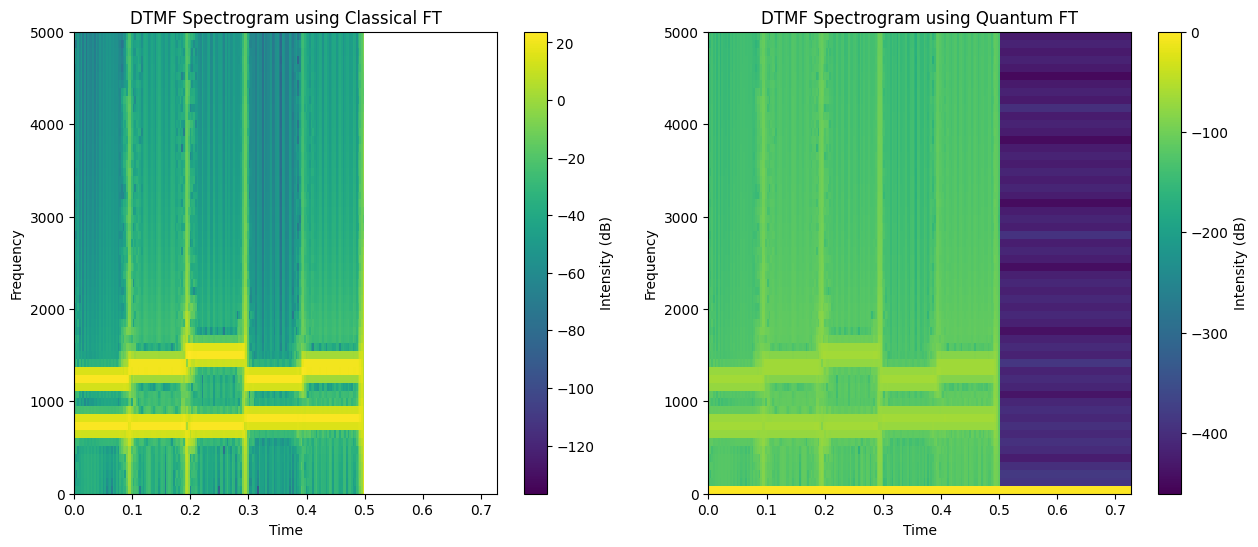

In [34]:
freqs = np.arange(Nwin)*sample_rate/Nwin
times = np.arange(Ns)*Nwin/(s*sample_rate)

fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Plotting the first graph
pcm1 = axs[0].pcolorfast(times,freqs,10*np.log(np.abs(fft))) #log scale (in decibels)

# Plotting the second graph
pcm2 = axs[1].pcolorfast(times,freqs,10*np.log(np.abs(qft))) #log scale (in decibels)

# Add colorbars for each subplot
fig.colorbar(pcm1, ax=axs[0], label='Intensity (dB)')
fig.colorbar(pcm2, ax=axs[1], label='Intensity (dB)')

# Set titles and labels
axs[0].set_title('DTMF Spectrogram using Classical FT')
axs[1].set_title('DTMF Spectrogram using Quantum FT')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Frequency')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Frequency')

axs[0].set_ylim(0,5000)
axs[1].set_ylim(0,5000)